<a href="https://colab.research.google.com/github/kulaginv/cvr_course/blob/main/notebooks/nn_sem5_pt2_hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Domik Dataset

In [3]:
class DomikDataset(Dataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__()
        self.house_width = 0.6
        self.house_height = 0.7
        self.roof_height = 0.3
        
        self.points, self.targets = self._generate(dataset_size, noise)

    def _left_roof(self, point):
        b = (0.5 * self.house_height - (self.house_height + self.roof_height) * (1 - self.house_width) / 2) / \
            (0.5 - (1 - self.house_width) / 2)
        k =  2 * (self.house_height - b) / (1 - self.house_width)
        return k * point[0] + b >= point[1]

    def _right_roof(self, point):
        b = (0.5 * self.house_height - (self.house_height + self.roof_height) * (1 + self.house_width) / 2) / \
            (0.5 - (1 + self.house_width) / 2)
        k = 2 * (self.house_height - b) / (1 + self.house_width)
        return k * point[0] + b >= point[1]
    
    
    def _generate(self, size, noise):
        points = [[random.random(), random.random()] for i in range(size)]

        targets = []
        for point in points:
            if (1 - self.house_width) / 2 <= point[0] <= (1 + self.house_width) / 2 and \
                self._left_roof(point) and self._right_roof(point):   
                inside = 1.
            else:
                inside = 0.

            if random.random() < noise:
                inside = 1. - inside

            targets.append(torch.tensor([inside], device=device))

        return points, targets
    
    def show(self, dividing_criterion=lambda s: 1 if s > 0.5 else 0):
        domik_x = []
        domik_y = []
        nedomik_x = []
        nedomik_y = []

        for sample in self:
            point, target = sample
            if dividing_criterion(target):
                domik_x.append(point[0])
                domik_y.append(point[1])
            else: 
                nedomik_x.append(point[0])
                nedomik_y.append(point[1])

        plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y,'.')

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
               
        sample = (torch.tensor(self.points[idx], device=device), self.targets[idx])

        return sample

# Train function

In [4]:
def train(network, train_dataset, epochs, criterion, optimizer):
    loss_epochs = []
    for idx in range(epochs):
        loss_samples = []
        for sample in train_dataset:
            optimizer.zero_grad()   # zero the gradient buffers
            point, target = sample
            output = network(point)
            loss = criterion(output, target.to(device))
            loss.backward()
            loss_samples.append(loss.data.numpy())
            optimizer.step()    # Does the update

        loss_samples_mean = float(sum(loss_samples)) / len (loss_samples)
        print(f"Epoch {idx: >8} Loss: {loss_samples_mean}")
        loss_epochs.append(loss_samples_mean)

    plt.plot(loss_epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show() 

# Test function

In [5]:
def test(network, test_dataset, dividing_criterion):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            total += 1
            correct += (dividing_criterion(output) == dividing_criterion(target))

            # dividing dataset for plotting
            if dividing_criterion(output):
                
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

# First steps

## Dataset

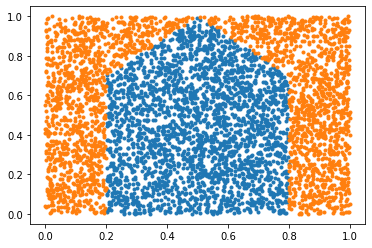

In [6]:
DATASET_SIZE = 5000
domik = DomikDataset(DATASET_SIZE)

data = DataLoader(domik, batch_size=1)

# plotting
domik.show()

## Net

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 1)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        return x

net = Net().float().to(device)
print(net)

In [7]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 40)
        self.fc2 = nn.Linear(40, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=1, bias=True)
)


## Train

Epoch        0 Loss: 0.13815881408318845
Epoch        1 Loss: 0.06217243435976757
Epoch        2 Loss: 0.054051906921139536
Epoch        3 Loss: 0.0478043961961685
Epoch        4 Loss: 0.04485299398302164
Epoch        5 Loss: 0.04130191186654953
Epoch        6 Loss: 0.03844486456781773
Epoch        7 Loss: 0.03717461753789754
Epoch        8 Loss: 0.03499499516756597
Epoch        9 Loss: 0.03346544304635344
Epoch       10 Loss: 0.032260408595550835
Epoch       11 Loss: 0.030898248980344975
Epoch       12 Loss: 0.030830344045897625
Epoch       13 Loss: 0.028869329773768607
Epoch       14 Loss: 0.029077596106854127
Epoch       15 Loss: 0.026971340575797045
Epoch       16 Loss: 0.02757612849787418
Epoch       17 Loss: 0.02666190824379783
Epoch       18 Loss: 0.026097490330501672
Epoch       19 Loss: 0.025387816839018428
Epoch       20 Loss: 0.024023531376339776
Epoch       21 Loss: 0.024104261099386366
Epoch       22 Loss: 0.023310359681665713
Epoch       23 Loss: 0.022788344735427093
Epoc

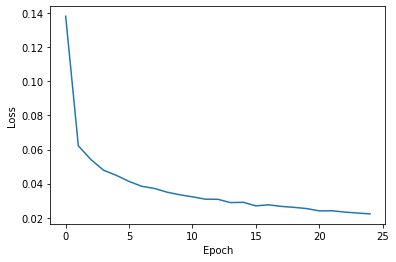

In [8]:
EPOCHS_TO_TRAIN = 25
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.1))

Epoch        0 Loss: 0.010784136122026142
Epoch        1 Loss: 0.010211061287646483
Epoch        2 Loss: 0.009978758867549191
Epoch        3 Loss: 0.009786870522272737
Epoch        4 Loss: 0.009623483922233063
Epoch        5 Loss: 0.009477706374624731
Epoch        6 Loss: 0.009350458762387168
Epoch        7 Loss: 0.009238397153893928
Epoch        8 Loss: 0.00913571904676185
Epoch        9 Loss: 0.009046764157579826
Epoch       10 Loss: 0.008956226598495478
Epoch       11 Loss: 0.008878489815145767
Epoch       12 Loss: 0.00880926579611873
Epoch       13 Loss: 0.008740041263151921
Epoch       14 Loss: 0.008675673759329481
Epoch       15 Loss: 0.00861451989130638
Epoch       16 Loss: 0.008556654483989979
Epoch       17 Loss: 0.00850435158649777
Epoch       18 Loss: 0.00845133310081065
Epoch       19 Loss: 0.00840349252213986
Epoch       20 Loss: 0.008355179509678026
Epoch       21 Loss: 0.008316619130716685
Epoch       22 Loss: 0.00827651286125481
Epoch       23 Loss: 0.008243034824120013

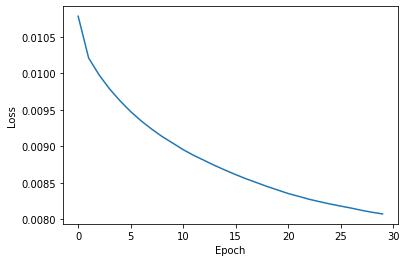

In [9]:
EPOCHS_TO_TRAIN = 30
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.01))

## Test

Accuracy of the network on the 25000 test samples: 99.284


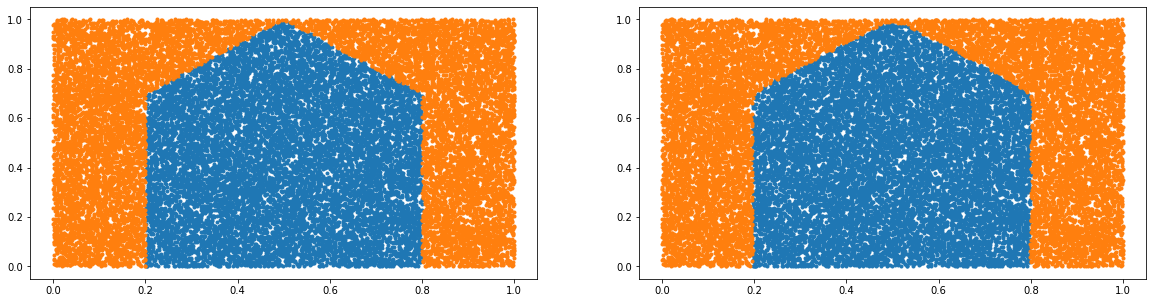

In [10]:
test_dataset = DomikDataset(DATASET_SIZE*5)
test(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

Accuracy of the network on the 25000 test samples: 99.284

# Domik dataset for multi classes

In [11]:
class MultiClassDomikDataset(DomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def show(self, dividing_criterion=lambda s: s[0] > s[1]):
        #super().show(dividing_criterion)
        super().show()
        
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, target in enumerate(targets):
            targets[i] = int(targets[i].item())
        return points, targets

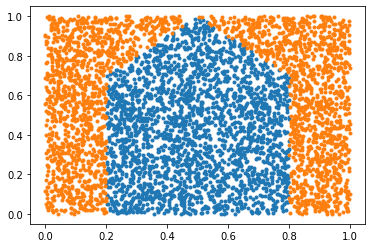

In [12]:
DATASET_SIZE = 5000
domik = MultiClassDomikDataset(DATASET_SIZE)

data = DataLoader(domik, batch_size=3)

# plotting
domik.show()

## Net

In [13]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 40)
        self.fc2 = nn.Linear(40, 2)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=2, bias=True)
)


## Train

Epoch        0 Loss: 0.66168735887862
Epoch        1 Loss: 0.41135173270045305
Epoch        2 Loss: 0.3143534473979865
Epoch        3 Loss: 0.28685855809966493
Epoch        4 Loss: 0.271953198965803
Epoch        5 Loss: 0.2109279190064084
Epoch        6 Loss: 0.1258874513954271
Epoch        7 Loss: 0.11235281240095718
Epoch        8 Loss: 0.10529776269965262
Epoch        9 Loss: 0.10023325603901533
Epoch       10 Loss: 0.09545381728824824
Epoch       11 Loss: 0.09176790561611954
Epoch       12 Loss: 0.08717664928800387
Epoch       13 Loss: 0.08579453910783956
Epoch       14 Loss: 0.08221468028562887
Epoch       15 Loss: 0.0803607995524475
Epoch       16 Loss: 0.07830143817903423
Epoch       17 Loss: 0.07679911320226053
Epoch       18 Loss: 0.07517192838213665
Epoch       19 Loss: 0.07345115200127414
Epoch       20 Loss: 0.07108271002986825
Epoch       21 Loss: 0.07047574116216311
Epoch       22 Loss: 0.06904602689824264
Epoch       23 Loss: 0.06761088044449173
Epoch       24 Loss: 0.06

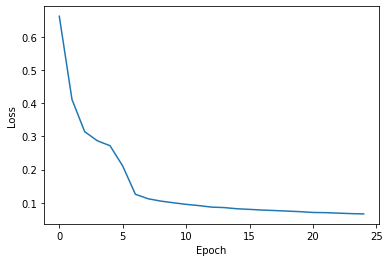

In [14]:
EPOCHS_TO_TRAIN = 25
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.1))

Epoch        0 Loss: 0.03719018287622559
Epoch        1 Loss: 0.03415808818372129
Epoch        2 Loss: 0.03361236381247041
Epoch        3 Loss: 0.03321534356463915
Epoch        4 Loss: 0.032904484761644634
Epoch        5 Loss: 0.032663023252024755
Epoch        6 Loss: 0.032443469686013006
Epoch        7 Loss: 0.03226529228200506
Epoch        8 Loss: 0.03207645939916763
Epoch        9 Loss: 0.03192275896304268
Epoch       10 Loss: 0.0317691397926961
Epoch       11 Loss: 0.031621026587697595
Epoch       12 Loss: 0.031471553536918113
Epoch       13 Loss: 0.0313332636721877
Epoch       14 Loss: 0.03119531319000047
Epoch       15 Loss: 0.031056600024780587
Epoch       16 Loss: 0.030917462951744745
Epoch       17 Loss: 0.030784107015215573
Epoch       18 Loss: 0.0306622348569186
Epoch       19 Loss: 0.03054211075085142
Epoch       20 Loss: 0.03041891576413514
Epoch       21 Loss: 0.0302914717757958
Epoch       22 Loss: 0.030181746860913808
Epoch       23 Loss: 0.030061435665655074
Epoch     

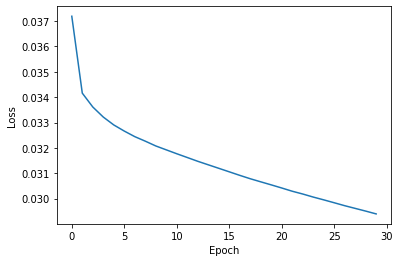

In [15]:
EPOCHS_TO_TRAIN = 30
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.01))

## Test

In [16]:
def test_multiple(network, test_dataset, dividing_criterion):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            _, output = torch.max(output, 0)
            total += 1
            correct += (dividing_criterion(output) == dividing_criterion(target))

            # dividing dataset for plotting
            if dividing_criterion(output):
                
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

Accuracy of the network on the 25000 test samples: 99.336


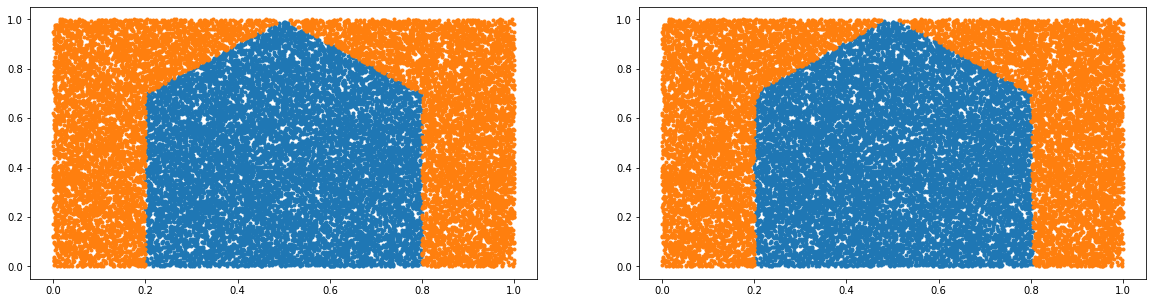

In [17]:
test_dataset = MultiClassDomikDataset(DATASET_SIZE*5)
test_multiple(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

Accuracy of the network on the 25000 test samples: 99.336

# Domik with window dataset

In [18]:
class WindowedDomikDataset(DomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def _window(self, point, width=0.3, height=0.3, x=0.5, y='middle'):
        if y == 'middle':
            y = self.house_height / 2
        is_window = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_window
    
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, point in enumerate(points):
            if self._window(point):
                targets[i] = torch.tensor([0.], device=device)
        return points, targets

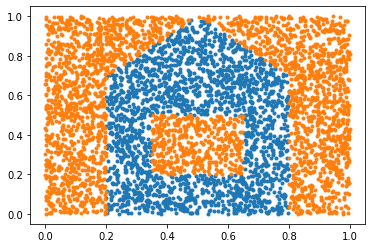

In [19]:
DATASET_SIZE = 5000
domik = WindowedDomikDataset(DATASET_SIZE)

# plotting
domik.show()

## Net

In [29]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 60)
        self.fc2 = nn.Linear(60, 40)
        self.fc3 = nn.Linear(40, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=1, bias=True)
)


## Train

Epoch        0 Loss: 0.21709783138790545
Epoch        1 Loss: 0.1649971580536884
Epoch        2 Loss: 0.1523650819404289
Epoch        3 Loss: 0.14390985260198041
Epoch        4 Loss: 0.1400543848497719
Epoch        5 Loss: 0.11429999753844358
Epoch        6 Loss: 0.09105968413993239
Epoch        7 Loss: 0.0864780708985637
Epoch        8 Loss: 0.0785046400435523
Epoch        9 Loss: 0.07808712432278733
Epoch       10 Loss: 0.07158774512873874
Epoch       11 Loss: 0.07050176699126519
Epoch       12 Loss: 0.07058446038196423
Epoch       13 Loss: 0.0641977298694849
Epoch       14 Loss: 0.06581353879509762
Epoch       15 Loss: 0.06441776479891417
Epoch       16 Loss: 0.06545975918453083
Epoch       17 Loss: 0.06063087711454978
Epoch       18 Loss: 0.05925379800892734
Epoch       19 Loss: 0.05762411104211282
Epoch       20 Loss: 0.05756839140053937
Epoch       21 Loss: 0.05898232498632234
Epoch       22 Loss: 0.06406051717660613
Epoch       23 Loss: 0.05659804523507157
Epoch       24 Loss: 0

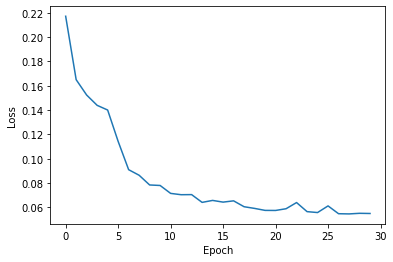

In [30]:
EPOCHS_TO_TRAIN = 30
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.1))

Epoch        0 Loss: 0.019999033038063295
Epoch        1 Loss: 0.01601454137830612
Epoch        2 Loss: 0.015298454700466048
Epoch        3 Loss: 0.014946227748052906
Epoch        4 Loss: 0.014735990049024346
Epoch        5 Loss: 0.014559539344246758
Epoch        6 Loss: 0.014286866431189833
Epoch        7 Loss: 0.014104444671994494
Epoch        8 Loss: 0.013979221405029489
Epoch        9 Loss: 0.013900527206160734
Epoch       10 Loss: 0.013798176349999327
Epoch       11 Loss: 0.013741744267378826
Epoch       12 Loss: 0.01370391224538276
Epoch       13 Loss: 0.013622697342713777
Epoch       14 Loss: 0.013530777125952232
Epoch       15 Loss: 0.01347208843735024
Epoch       16 Loss: 0.01338561908677858
Epoch       17 Loss: 0.013333429038836948
Epoch       18 Loss: 0.013270503522159572
Epoch       19 Loss: 0.013202631373643666
Epoch       20 Loss: 0.013137049435343644
Epoch       21 Loss: 0.013045493621783606
Epoch       22 Loss: 0.013027111935897534
Epoch       23 Loss: 0.012936041333042

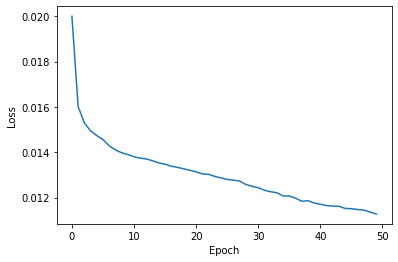

In [32]:
EPOCHS_TO_TRAIN = 50
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.01))

Epoch        0 Loss: 0.009424436825078186
Epoch        1 Loss: 0.008776380631961107
Epoch        2 Loss: 0.008722995223058812
Epoch        3 Loss: 0.008695745739058312
Epoch        4 Loss: 0.008673875871687851
Epoch        5 Loss: 0.008654285746286284
Epoch        6 Loss: 0.008639221772789207
Epoch        7 Loss: 0.008624255111642401
Epoch        8 Loss: 0.008610069613315162
Epoch        9 Loss: 0.008596026450871982
Epoch       10 Loss: 0.008582669037774661
Epoch       11 Loss: 0.00856868085692931
Epoch       12 Loss: 0.008558877176160487
Epoch       13 Loss: 0.00854721548572307
Epoch       14 Loss: 0.008536177502706306
Epoch       15 Loss: 0.008523199337364592
Epoch       16 Loss: 0.008512887191416104
Epoch       17 Loss: 0.008501889325319444
Epoch       18 Loss: 0.008489879182683475
Epoch       19 Loss: 0.008478247433246645
Epoch       20 Loss: 0.008468688926874138
Epoch       21 Loss: 0.008459984577281279
Epoch       22 Loss: 0.00844802456527432
Epoch       23 Loss: 0.00843585787520

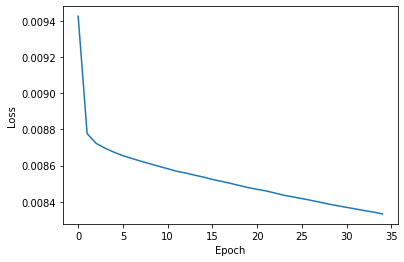

In [34]:
EPOCHS_TO_TRAIN = 35
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.001))

## Test

Accuracy of the network on the 25000 test samples: 99.128


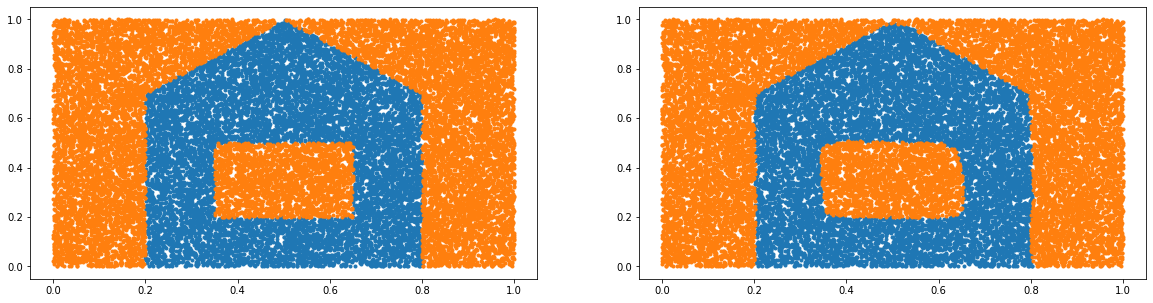

In [35]:
test_dataset = WindowedDomikDataset(DATASET_SIZE*5)
test(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

Accuracy of the network on the 25000 test samples: 99.128

# Homework

- [ ] Обучить обычный домик (Accuracy >98%). 1 балл
- [ ] Использовать для этого двухслойную сеть. 1 балл
- [ ] Обучить домик с многоклассовой классификацией (зa тавтологию извините) (Accuracy >98%). 1 балл
- [ ] Использовать для этого двухслойную сеть. 1 балл
- [ ] Обучить домик с окошком (Accuracy >98%). 1 балл
- [ ] Использовать для этого трехслойную сеть. 1 балл
- [ ] Обучить домик с дверью и двумя окошками (Accuracy >98%). 2 балла
- [ ] Использовать для этого трехслойную сеть. 2 балла

#### ВАЖНО! ВЫБОРКУ УВЕЛИЧИВАТЬ НЕЛЬЗЯ!

Домашку выполняем в этой тетрадке и заливаем на гит, инструкция - https://youtu.be/lPcEQJiHDfg. Форма для сдачи - https://forms.gle/RJtnENVjGP6H5oPn6 \
Удачи!

## Domik with door and 2 windows dataset

In [36]:
class DoorDomikDataset(WindowedDomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def _door(self, point, width=0.2, height=0.5, x=0.5):
        y = height / 2
        is_door = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_door
    
    def _window(self, point, width=0.1, height=0.3, x=0.5, y='middle'):
        if y == 'middle':
            y = self.house_height / 2
        is_window = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_window
    
    def show(self):
        domik_x = []
        domik_y = []
        nedomik_x = []
        nedomik_y = []
        door_x = []
        door_y = []

        for sample in self:
            point, target = sample
            if target == 1:
                domik_x.append(point[0])
                domik_y.append(point[1])
            elif target == 0: 
                nedomik_x.append(point[0])
                nedomik_y.append(point[1])
            else:
                door_x.append(point[0])
                door_y.append(point[1])

        plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y,'.', door_x, door_y, '.')
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, point in enumerate(points):
            if self._window(point, x=0.3):
                targets[i] = torch.tensor([0.], device=device)
            if self._window(point, x=0.7):
                targets[i] = torch.tensor([0.], device=device)
            if self._door(point):
                targets[i] = torch.tensor([2.], device=device)
                
            targets[i] = int(targets[i].item())
        return points, targets

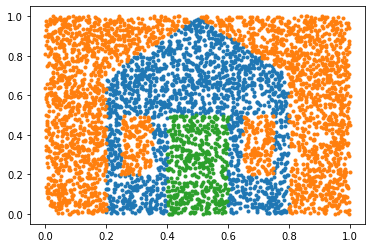

In [37]:
DATASET_SIZE = 5000
# generate dataset here
domik = DoorDomikDataset(DATASET_SIZE)

data = DataLoader(domik, batch_size=10)

# plotting
domik.show()

## Net

In [38]:
# create network here
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 80)
        self.fc2 = nn.Linear(80, 50)
        self.fc3 = nn.Linear(50, 3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)


## Train

Epoch        0 Loss: 0.9787149641513825
Epoch        1 Loss: 0.7207181683182716
Epoch        2 Loss: 0.61483807310462
Epoch        3 Loss: 0.4891087754666805
Epoch        4 Loss: 0.42276522105932235
Epoch        5 Loss: 0.3580151120647788
Epoch        6 Loss: 0.3354465511515737
Epoch        7 Loss: 0.3172643534168601
Epoch        8 Loss: 0.29857312816381454
Epoch        9 Loss: 0.2846102580726147
Epoch       10 Loss: 0.27141769018396733
Epoch       11 Loss: 0.26317640987504276
Epoch       12 Loss: 0.2558108702609316
Epoch       13 Loss: 0.24929211636073886
Epoch       14 Loss: 0.243177804145962
Epoch       15 Loss: 0.23630287110898643
Epoch       16 Loss: 0.231028314367868
Epoch       17 Loss: 0.22660522961802781
Epoch       18 Loss: 0.22298374895565212
Epoch       19 Loss: 0.2180908247686457
Epoch       20 Loss: 0.21599469948513433
Epoch       21 Loss: 0.2098784758336842
Epoch       22 Loss: 0.20558858007378877
Epoch       23 Loss: 0.20168988762167284
Epoch       24 Loss: 0.1993331039

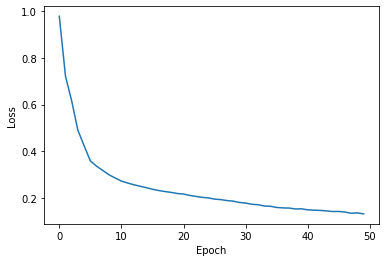

In [39]:
# train here
EPOCHS_TO_TRAIN = 50
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.1))

Epoch        0 Loss: 0.08119970551187726
Epoch        1 Loss: 0.07232989362482477
Epoch        2 Loss: 0.07047564962349133
Epoch        3 Loss: 0.06923587190281251
Epoch        4 Loss: 0.06823161144879851
Epoch        5 Loss: 0.06736668622853176
Epoch        6 Loss: 0.06663540979805112
Epoch        7 Loss: 0.06606214341458326
Epoch        8 Loss: 0.0654810294012641
Epoch        9 Loss: 0.06496066172716018
Epoch       10 Loss: 0.06443677027333797
Epoch       11 Loss: 0.0639054593285
Epoch       12 Loss: 0.0634281179358386
Epoch       13 Loss: 0.0630347099572009
Epoch       14 Loss: 0.06263364883375834
Epoch       15 Loss: 0.06223936332575431
Epoch       16 Loss: 0.06184356128532272
Epoch       17 Loss: 0.061511434495183495
Epoch       18 Loss: 0.06117355290197611
Epoch       19 Loss: 0.06085889064372168
Epoch       20 Loss: 0.06051542885102663
Epoch       21 Loss: 0.060224241194583555
Epoch       22 Loss: 0.05995031178764384
Epoch       23 Loss: 0.05963181965818512
Epoch       24 Loss: 

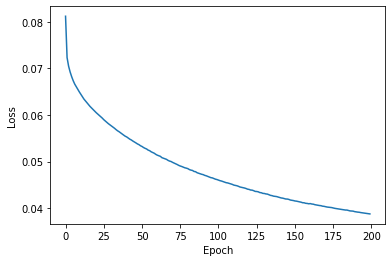

In [40]:
EPOCHS_TO_TRAIN = 200
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.01))

Epoch        0 Loss: 0.03386400746387807
Epoch        1 Loss: 0.033001173913338164
Epoch        2 Loss: 0.03289988589000649
Epoch        3 Loss: 0.032845305018160104
Epoch        4 Loss: 0.03281911038205948
Epoch        5 Loss: 0.032783982820133305
Epoch        6 Loss: 0.03276604142652963
Epoch        7 Loss: 0.032735682741843165
Epoch        8 Loss: 0.03272501965569239
Epoch        9 Loss: 0.03269848881313027
Epoch       10 Loss: 0.03268877477440486
Epoch       11 Loss: 0.03266657660632262
Epoch       12 Loss: 0.032657145177085053
Epoch       13 Loss: 0.03263618107013844
Epoch       14 Loss: 0.032625044244899926
Epoch       15 Loss: 0.03261109753370846
Epoch       16 Loss: 0.032600845582190174
Epoch       17 Loss: 0.03258453344329285
Epoch       18 Loss: 0.03257663536598142
Epoch       19 Loss: 0.03255569214372048
Epoch       20 Loss: 0.03255308308911202
Epoch       21 Loss: 0.032534395831731164
Epoch       22 Loss: 0.03253371575141563
Epoch       23 Loss: 0.032512613581957735
Epoch  

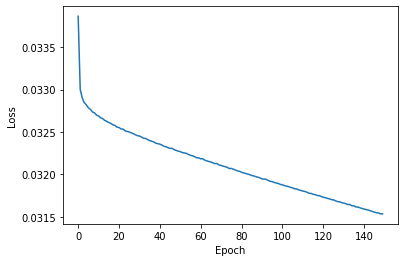

In [43]:
EPOCHS_TO_TRAIN = 150
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.001))

## Test

In [44]:
def test_door_domik(network, test_dataset):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []
    door_x = []
    door_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            _, output = torch.max(output, 0)
            total += 1
            correct += (output == target).sum().item()

            # dividing dataset for plotting
            if output == 1:
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            elif output == 2:
                door_x.append(inp[0])
                door_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.', door_x, door_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

Accuracy of the network on the 25000 test samples: 98.9


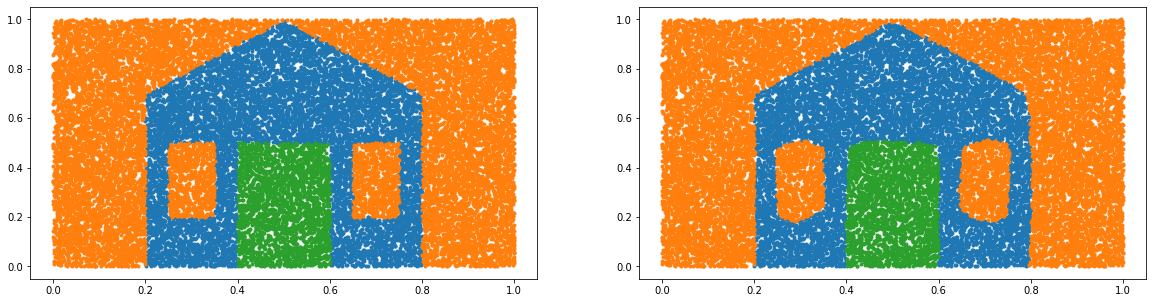

In [45]:
test_dataset = DoorDomikDataset(DATASET_SIZE*5)
test_door_domik(network=net, test_dataset=test_dataset)

Accuracy of the network on the 25000 test samples: 98.9